## Required Installations

In [2]:
!pip install transformers torch pandas numpy scikit-learn nltk wordcloud textblob matplotlib seaborn plotly tqdm

## Import Required Libraries and Initial Setup

In [1]:
"""
Import all required libraries and set initial configurations
"""
import os
import json
import logging
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModel, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (classification_report, precision_recall_fscore_support,
                           roc_auc_score, confusion_matrix)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import ast
import warnings
from torch.cuda.amp import autocast, GradScaler

warnings.filterwarnings('ignore')
print("All required libraries have been imported successfully!")

All required libraries have been imported successfully!


## Set Random Seeds and Configure Logging

In [3]:
"""
Set random seeds for reproducibility and configure logging
"""
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    print(f"Random seed set to {seed}")

set_seed()

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)
print("Logging configured successfully!")

Random seed set to 42
Logging configured successfully!


## Check CUDA availability

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Initialize NLTK Components

In [5]:
"""
Download and set up NLTK resources
"""
nltk_data_dir = '/content/nltk_data'
os.makedirs(nltk_data_dir, exist_ok=True)

# Download NLTK data
resources = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'omw-1.4']
for resource in resources:
    nltk.download(resource, download_dir=nltk_data_dir, quiet=True)
    print(f"Downloaded NLTK resource: {resource}")

print("\nNLTK setup completed!")

Downloaded NLTK resource: punkt
Downloaded NLTK resource: stopwords
Downloaded NLTK resource: wordnet
Downloaded NLTK resource: averaged_perceptron_tagger
Downloaded NLTK resource: omw-1.4

NLTK setup completed!


## Define DataVisualizer Class

In [6]:
"""
Class for visualizing data analysis and training progress
"""
class DataVisualizer:
    def __init__(self, df=None):
        self.df = df

    def plot_confusion_matrices(self, predictions, labels, class_names):
        n_classes = len(class_names)
        n_cols = 3
        n_rows = (n_classes + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()

        for idx, class_name in enumerate(class_names):
            if idx < len(axes):
                pred_class = (predictions[:, idx] >= 0.5).astype(int)
                true_class = labels[:, idx]
                cm = confusion_matrix(true_class, pred_class)
                sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
                axes[idx].set_title(f'Confusion Matrix - {class_name}')
                axes[idx].set_xlabel('Predicted')
                axes[idx].set_ylabel('True')

        for idx in range(len(class_names), len(axes)):
            fig.delaxes(axes[idx])

        plt.tight_layout()
        plt.show()

    def plot_category_distribution(self):
        if self.df is None:
            print("No DataFrame provided!")
            return

        categories = []
        for cats in self.df['Category']:
            categories.extend(cats)

        category_counts = Counter(categories)
        total = sum(category_counts.values())
        sorted_categories = dict(sorted(category_counts.items(),
                                     key=lambda x: x[1], reverse=True))

        plt.figure(figsize=(15, 6))
        bars = plt.bar(range(len(sorted_categories)), sorted_categories.values())
        plt.title('Category Distribution', size=14, pad=20)
        plt.xlabel('Categories', size=12)
        plt.ylabel('Count', size=12)

        plt.xticks(range(len(sorted_categories)), sorted_categories.keys(),
                  rotation=45, ha='right')

        for bar in bars:
            height = bar.get_height()
            percentage = (height/total) * 100
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}\n({percentage:.1f}%)',
                    ha='center', va='bottom')

        plt.tight_layout()
        plt.show()
        print("\nCategory distribution plot generated!")

print("DataVisualizer class defined successfully!")

DataVisualizer class defined successfully!


## Define Custom Loss Function (Focal Loss)

In [ ]:
"""
Implementation of Focal Loss for handling class imbalance
"""
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.5, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

print("Focal Loss class defined successfully!")

## Define Text Preprocessor

In [14]:
"""
Text preprocessing utilities
"""

import nltk
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

class TextPreprocessor:
    def __init__(self):
        self.stop_words = stopwords.words('english')
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        if pd.isna(text) or not isinstance(text, str):
            return ""

        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def preprocess_text(self, text, augment=False):
        try:
            text = self.clean_text(text)
            if not text:
                return ""

            words = text.split()
            words = [
                self.lemmatizer.lemmatize(word)
                for word in words
                if word not in self.stop_words and len(word) > 2
            ]

            return ' '.join(words)

        except Exception as e:
            logger.error(f"Error in text preprocessing: {e}")
            return text

preprocessor = TextPreprocessor()
sample_text = "This is a sample text for preprocessing! It contains some special characters & numbers 123."
processed_text = preprocessor.preprocess_text(sample_text)
print("Text Preprocessor test:")
print(f"Original text: {sample_text}")
print(f"Processed text: {processed_text}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Text Preprocessor test:
Original text: This is a sample text for preprocessing! It contains some special characters & numbers 123.
Processed text: sample text preprocessing contains special character number 123


## Load and Prepare Data

In [16]:
"""
Load and prepare the training and test data
"""
# Load data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Clean category strings
train_df['Category'] = train_df['Category'].apply(
    lambda x: ast.literal_eval(x) if pd.notnull(x) else []
)

# Combine text columns
train_df['combined_text'] = train_df.apply(
    lambda x: f"{x['reviews']} {x['product_description']}",
    axis=1
)

print("Data Loading Summary:")
print("\nTraining Data Info:")
print(train_df.info())
print("\nSample Categories:")
print(train_df['Category'].head())
print("\nSample Combined Text:")
print(train_df['combined_text'].head())

Data Loading Summary:

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            264 non-null    int64 
 1   title                 264 non-null    object
 2   price                 264 non-null    object
 3   rating                264 non-null    object
 4   total_reviews         264 non-null    object
 5   availability_status   264 non-null    object
 6   manufacturer          264 non-null    object
 7   country_of_origin     264 non-null    object
 8   os                    264 non-null    object
 9   ram                   264 non-null    object
 10  product_dimensions    264 non-null    object
 11  weight                264 non-null    object
 12  batteries             264 non-null    object
 13  special_features      264 non-null    object
 14  form_factor           264 non-null    object
 1

## Initial Data Analysis

Generating category distribution plot...


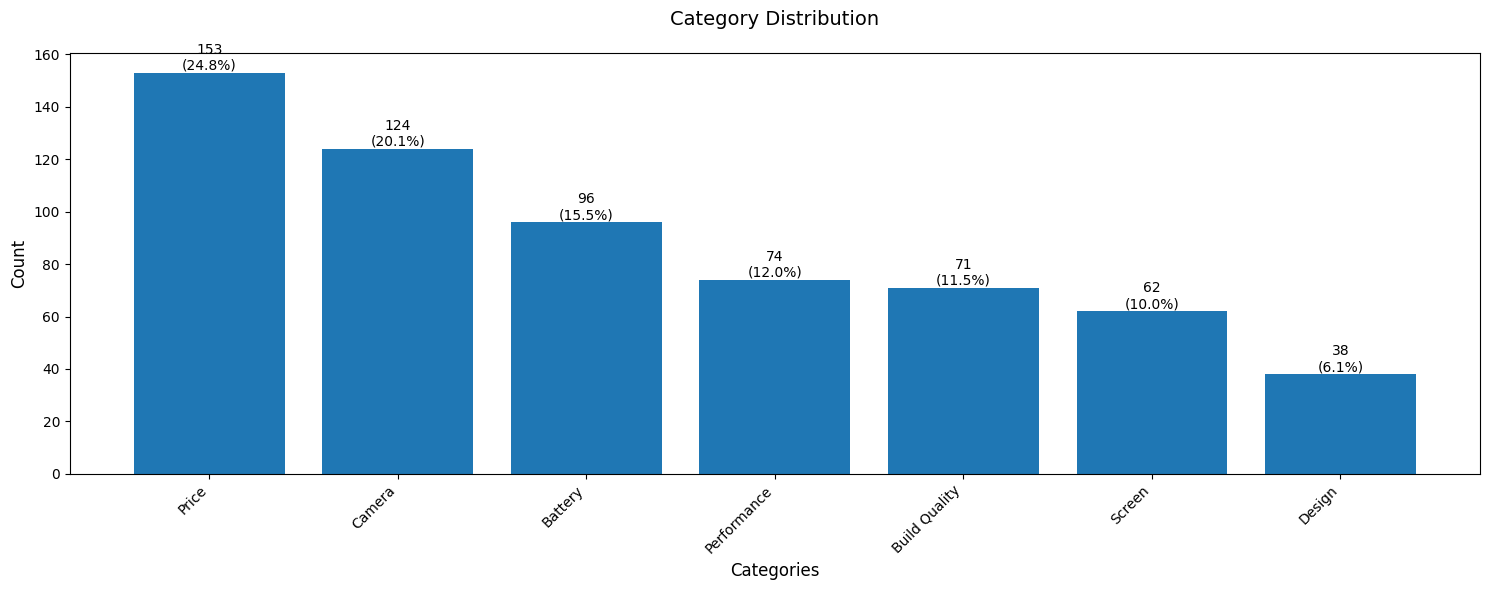


Category distribution plot generated!


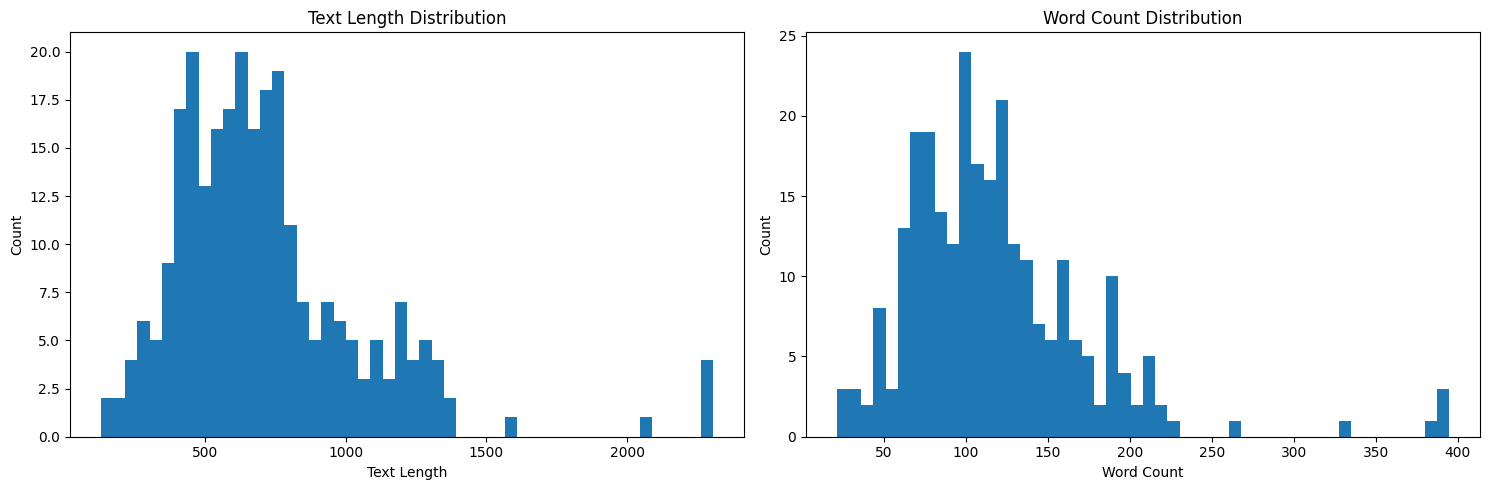


Text Statistics:
Average text length: 720.27 characters
Average word count: 118.17 words


In [19]:
"""
Perform initial data analysis and visualization
"""
visualizer = DataVisualizer(train_df)

print("Generating category distribution plot...")
visualizer.plot_category_distribution()

# Text length analysis
text_lengths = train_df['combined_text'].str.len()
word_counts = train_df['combined_text'].str.split().str.len()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(word_counts, bins=50)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print("\nText Statistics:")
print(f"Average text length: {text_lengths.mean():.2f} characters")
print(f"Average word count: {word_counts.mean():.2f} words")

## Define Dataset Class

In [20]:
"""
Custom dataset class for handling product review data
"""
class ProductReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256, augment=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.augment = augment
        self.preprocessor = TextPreprocessor()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'labels': torch.FloatTensor(label)
        }

print("ProductReviewDataset class defined successfully!")

ProductReviewDataset class defined successfully!


## Define Model Architecture

In [21]:
"""
Improved product classifier model architecture
"""
class ImprovedProductClassifier(nn.Module):
    def __init__(self, n_classes, model_name='bert-base-uncased', dropout_rate=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)

        # Freeze the first 8 layers of BERT
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False
        for i in range(8):
            for param in self.bert.encoder.layer[i].parameters():
                param.requires_grad = False

        self.attention = nn.MultiheadAttention(768, 8, dropout=dropout_rate)
        self.lstm = nn.LSTM(768, 384, num_layers=2, bidirectional=True,
                           dropout=dropout_rate, batch_first=True)

        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.classifier = nn.Sequential(
            nn.Linear(768 * 2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, n_classes)
        )

        self.layer_norm = nn.LayerNorm(768)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True,
            return_dict=True
        )

        sequence_output = self.layer_norm(outputs.last_hidden_state)

        attention_output, _ = self.attention(
            sequence_output.permute(1, 0, 2),
            sequence_output.permute(1, 0, 2),
            sequence_output.permute(1, 0, 2)
        )
        attention_output = attention_output.permute(1, 0, 2)

        lstm_output, _ = self.lstm(attention_output)

        avg_pooled = self.avg_pool(lstm_output.transpose(1, 2)).squeeze(-1)
        max_pooled = self.max_pool(lstm_output.transpose(1, 2)).squeeze(-1)

        pooled = torch.cat([avg_pooled, max_pooled], dim=1)

        return self.classifier(pooled)

print("ImprovedProductClassifier model architecture defined successfully!")

ImprovedProductClassifier model architecture defined successfully!


## Prepare Data for Training

Data preparation completed!
Number of classes: 7
Training samples: 211
Validation samples: 53


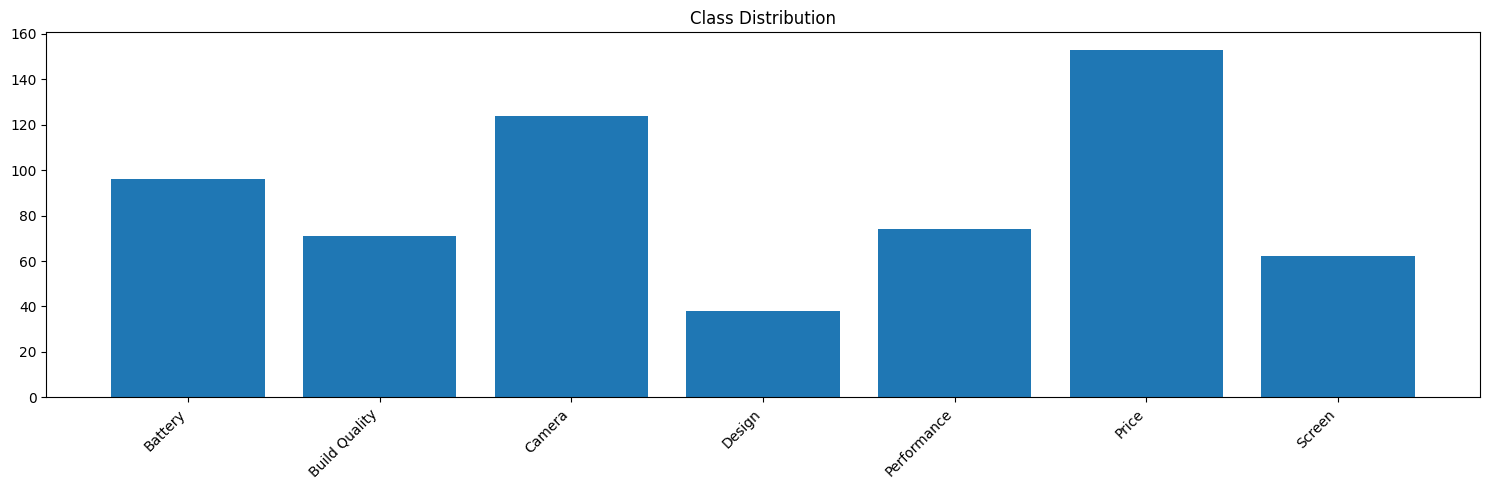

In [22]:
"""
Prepare data for model training
"""
# Prepare labels
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(train_df['Category'])
class_names = mlb.classes_

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['combined_text'].values,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels.sum(axis=1)
)

print("Data preparation completed!")
print(f"Number of classes: {len(class_names)}")
print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

# Display class distribution
class_counts = labels.sum(axis=0)
plt.figure(figsize=(15, 5))
plt.bar(class_names, class_counts)
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

## Create Data Loaders

In [23]:
"""
Create data loaders for training and validation
"""
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
print("Tokenizer initialized successfully!")

# Create datasets
train_dataset = ProductReviewDataset(
    train_texts,
    train_labels,
    tokenizer,
    max_len=256,
    augment=True
)

val_dataset = ProductReviewDataset(
    val_texts,
    val_labels,
    tokenizer,
    max_len=256,
    augment=False
)

# Calculate class weights for weighted sampling
class_weights = 1.0 / np.mean(train_labels, axis=0)
sample_weights = np.sum(train_labels * class_weights, axis=1)

train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_labels),
    replacement=True
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=train_sampler,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("DataLoaders created successfully!")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Test a batch
sample_batch = next(iter(train_loader))
print("\nSample batch structure:")
for key, value in sample_batch.items():
    print(f"{key}: {value.shape}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer initialized successfully!
DataLoaders created successfully!
Number of training batches: 14
Number of validation batches: 4

Sample batch structure:
input_ids: torch.Size([16, 256])
attention_mask: torch.Size([16, 256])
token_type_ids: torch.Size([16, 256])
labels: torch.Size([16, 7])


## Define Training Components

In [24]:
"""
Define training utilities including ModelTrainer class
"""
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device, class_names):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.class_names = class_names
        self.scaler = GradScaler()
        self.visualizer = DataVisualizer()

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        progress_bar = tqdm(self.train_loader, desc='Training')

        for batch in progress_bar:
            self.optimizer.zero_grad()

            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            token_type_ids = batch['token_type_ids'].to(self.device)
            labels = batch['labels'].to(self.device)

            with autocast():
                outputs = self.model(input_ids, attention_mask, token_type_ids)
                loss = self.criterion(outputs, labels)

            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.scaler.step(self.optimizer)
            self.scaler.update()

            if self.scheduler is not None:
                self.scheduler.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        return total_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            progress_bar = tqdm(self.val_loader, desc='Validating')
            for batch in progress_bar:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                token_type_ids = batch['token_type_ids'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids, attention_mask, token_type_ids)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()
                predictions = torch.sigmoid(outputs).cpu().numpy()
                all_preds.extend(predictions)
                all_labels.extend(labels.cpu().numpy())

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        metrics = {}
        pred_labels = (all_preds > 0.5).astype(int)

        for i, class_name in enumerate(self.class_names):
            precision, recall, f1, _ = precision_recall_fscore_support(
                all_labels[:, i],
                pred_labels[:, i],
                average='binary'
            )

            try:
                roc_auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
            except:
                roc_auc = 0

            metrics[class_name] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc_auc
            }

        return total_loss / len(self.val_loader), metrics, all_preds, all_labels

print("ModelTrainer class defined successfully!")

ModelTrainer class defined successfully!


## Custom Loss Function

In [26]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.5, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

## Initialize Model and Training Components

In [27]:
"""
Initialize model, optimizer, and other training components
"""
# Initialize model
model = ImprovedProductClassifier(n_classes=len(class_names))
model = model.to(device)
print("Model initialized successfully!")

# Set up parameter groups with different learning rates
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in model.named_parameters()
                  if not any(nd in n for nd in no_decay) and 'bert' in n],
        'lr': 2e-5,
        'weight_decay': 0.01
    },
    {
        'params': [p for n, p in model.named_parameters()
                  if any(nd in n for nd in no_decay) and 'bert' in n],
        'lr': 2e-5,
        'weight_decay': 0.0
    },
    {
        'params': [p for n, p in model.named_parameters()
                  if not any(nd in n for nd in no_decay) and 'bert' not in n],
        'lr': 2e-4,
        'weight_decay': 0.01
    },
    {
        'params': [p for n, p in model.named_parameters()
                  if any(nd in n for nd in no_decay) and 'bert' not in n],
        'lr': 2e-4,
        'weight_decay': 0.0
    }
]

# Initialize optimizer and scheduler
optimizer = AdamW(optimizer_grouped_parameters)
total_steps = len(train_loader) * 100  # 100 epochs

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[2e-5, 2e-5, 2e-4, 2e-4],
    total_steps=total_steps,
    pct_start=0.1,
    anneal_strategy='cos'
)

# Initialize criterion
criterion = FocalLoss(alpha=1.5, gamma=2)

# Initialize trainer
trainer = ModelTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    class_names=class_names
)

print("All training components initialized successfully!")

Model initialized successfully!
All training components initialized successfully!


## Training Loop

In [28]:
"""
Main training loop with progress tracking
"""
# Initialize training variables
best_val_f1 = 0
patience = 5
patience_counter = 0
history = defaultdict(list)
num_epochs = 100

print("Starting training loop...")
print(f"Training for {num_epochs} epochs with patience {patience}")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training phase
    train_loss = trainer.train_epoch()
    history['train_loss'].append(train_loss)

    # Validation phase
    val_loss, metrics, predictions, labels = trainer.validate()
    history['val_loss'].append(val_loss)
    history['metrics'].append(metrics)

    # Calculate average F1 score
    avg_f1 = np.mean([m['f1'] for m in metrics.values()])

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Average F1: {avg_f1:.4f}")

    # Plot metrics every 5 epochs
    if (epoch + 1) % 5 == 0:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train')
        plt.plot(history['val_loss'], label='Validation')
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        f1_scores = [np.mean([m['f1'] for m in epoch_metrics.values()])
                    for epoch_metrics in history['metrics']]
        plt.plot(f1_scores)
        plt.title('Average F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')

        plt.tight_layout()
        plt.show()

    # Save best model and check for early stopping
    if avg_f1 > best_val_f1:
        best_val_f1 = avg_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_f1': best_val_f1,
            'config': {'num_epochs': num_epochs, 'patience': patience},
            'class_names': class_names,
            'history': history
        }, 'best_model.pt')
        print(f"Saved best model with F1: {best_val_f1:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

print("Training completed!")

Starting training loop...
Training for 100 epochs with patience 5

Epoch 1/100


Training:   0%|          | 0/14 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-9072cf8ec580>", line 18, in <cell line: 14>
    train_loss = trainer.train_epoch()
  File "<ipython-input-24-60ddd6b372c5>", line 31, in train_epoch
    outputs = self.model(input_ids, attention_mask, token_type_ids)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "<ipython-input-21-87d5ae7a636a>", line 38, in forward
    outputs = self.bert(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/p

TypeError: object of type 'NoneType' has no len()

## Final Evaluation and Results

In [ ]:
"""
Evaluate the best model and display final results
"""
# Load best model
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print("Best model loaded successfully!")

# Final evaluation
_, final_metrics, final_predictions, final_labels = trainer.validate()

# Plot final confusion matrices
trainer.visualizer.plot_confusion_matrices(final_predictions, final_labels, class_names)

# Print final metrics
print("\nFinal Metrics:")
for class_name, metrics in final_metrics.items():
    print(f"\n{class_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

# Plot final training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Final Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
f1_scores = [np.mean([m['f1'] for m in epoch_metrics.values()])
            for epoch_metrics in history['metrics']]
plt.plot(f1_scores)
plt.title('Final Average F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

print("\nTraining and evaluation completed successfully!")

## Inference Pipeline

In [ ]:
"""
Create and test inference pipeline with the best model
"""
class InferencePipeline:
    def __init__(self, model_path='best_model.pt'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        checkpoint = torch.load(model_path, map_location=self.device)

        self.model = ImprovedProductClassifier(n_classes=len(checkpoint['class_names']))
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()

        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.class_names = checkpoint['class_names']
        self.preprocessor = TextPreprocessor()

    def predict(self, text, threshold=0.5):
        processed_text = self.preprocessor.preprocess_text(text)

        encoding = self.tokenizer.encode_plus(
            processed_text,
            add_special_tokens=True,
            max_length=256,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        token_type_ids = encoding['token_type_ids'].to(self.device)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask, token_type_ids)
            probabilities = torch.sigmoid(outputs).cpu().numpy()[0]

        results = []
        for class_name, prob in zip(self.class_names, probabilities):
            confidence = float(prob)
            is_predicted = confidence >= threshold
            results.append({
                'category': class_name,
                'confidence': confidence,
                'predicted': is_predicted
            })

        return sorted(results, key=lambda x: x['confidence'], reverse=True)

# Create pipeline and test it
pipeline = InferencePipeline('best_model.pt')
print("Inference pipeline created successfully!")

# Test predictions
test_texts = [
    "The camera quality is excellent with great detail in low light conditions",
    "Battery life is disappointing, barely lasts half a day",
    "The build quality is premium with a solid metal frame"
]

print("\nTesting predictions:")
for text in test_texts:
    print(f"\nInput: {text}")
    predictions = pipeline.predict(text)
    print("Predicted categories:")
    for pred in predictions:
        if pred['predicted']:
            print(f"{pred['category']}: {pred['confidence']:.4f}")

## Model Analysis

In [ ]:
"""
Analyze model predictions and performance in detail
"""
def analyze_prediction_distribution():
    # Get predictions for validation set
    all_predictions = []
    all_true_labels = []

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)
            predictions = torch.sigmoid(outputs).cpu().numpy()
            all_predictions.extend(predictions)
            all_true_labels.extend(batch['labels'].numpy())

    all_predictions = np.array(all_predictions)
    all_true_labels = np.array(all_true_labels)

    # Plot prediction distribution
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    for i, class_name in enumerate(class_names):
        plt.hist(all_predictions[:, i], bins=50, alpha=0.5, label=class_name)
    plt.title('Prediction Distribution by Class')
    plt.xlabel('Prediction Probability')
    plt.ylabel('Count')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2)
    plt.boxplot([all_predictions[:, i] for i in range(len(class_names))], labels=class_names)
    plt.title('Prediction Distribution Boxplot')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return all_predictions, all_true_labels

print("Running prediction distribution analysis...")
predictions, true_labels = analyze_prediction_distribution()

## Error Analysis

In [ ]:
"""
Analyze model errors and misclassifications
"""
def analyze_errors(predictions, true_labels, texts):
    errors = []
    pred_labels = (predictions > 0.5).astype(int)

    for i in range(len(texts)):
        if not np.array_equal(pred_labels[i], true_labels[i]):
            errors.append({
                'text': texts[i],
                'predicted': [class_names[j] for j in range(len(class_names)) if pred_labels[i][j] == 1],
                'true': [class_names[j] for j in range(len(class_names)) if true_labels[i][j] == 1],
                'probabilities': predictions[i]
            })

    return errors

print("\nAnalyzing prediction errors...")
errors = analyze_errors(predictions, true_labels, val_texts)

print(f"\nTotal number of errors: {len(errors)}")
print("\nSample error cases:")
for i, error in enumerate(errors[:5]):  # Show first 5 errors
    print(f"\nError case {i+1}:")
    print(f"Text: {error['text'][:100]}...")
    print(f"Predicted categories: {error['predicted']}")
    print(f"True categories: {error['true']}")

## Performance Visualization

In [ ]:
"""
Create detailed performance visualizations
"""
def plot_performance_metrics():
    # Calculate per-class metrics
    class_metrics = {}
    for i, class_name in enumerate(class_names):
        pred_labels = (predictions[:, i] > 0.5).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels[:, i], pred_labels, average='binary'
        )
        class_metrics[class_name] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    # Plot metrics
    metrics_df = pd.DataFrame(class_metrics).T

    plt.figure(figsize=(15, 6))
    metrics_df.plot(kind='bar', width=0.8)
    plt.title('Performance Metrics by Class')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return metrics_df

print("\nGenerating performance visualizations...")
metrics_df = plot_performance_metrics()

print("\nDetailed metrics by class:")
print(metrics_df)

## Save and Export Results

In [ ]:
"""
Save final results and model artifacts
"""
def save_results():
    results = {
        'model_performance': metrics_df.to_dict(),
        'training_history': {
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'metrics': history['metrics']
        },
        'class_names': class_names,
        'config': {
            'num_epochs': num_epochs,
            'batch_size': 16,
            'learning_rate': 2e-5,
            'model_architecture': 'ImprovedProductClassifier',
            'best_val_f1': best_val_f1
        }
    }

    # Save results to JSON
    with open('training_results.json', 'w') as f:
        json.dump(results, f, indent=4)

    print("Results saved successfully!")
    return results

final_results = save_results()

print("\nTraining and evaluation pipeline completed!")
print(f"Best validation F1 score: {best_val_f1:.4f}")
print(f"Model and results saved in current directory")